# Korzinka Inventory Forecasting — Full Pipeline
**Dataset**: Kaggle Store Item Demand Forecasting (5 years, 10 stores, 50 items)

Run cells top-to-bottom. No external src/ imports needed.

## 0. Setup

In [1]:
import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style='whitegrid')

# --- Locate project root regardless of CWD ---
_cwd = Path.cwd()
ROOT = _cwd.parent if _cwd.name == 'notebooks' else _cwd
os.chdir(ROOT)

TRAIN_CSV  = ROOT / 'data' / 'raw' / 'train.csv'
TEST_CSV   = ROOT / 'data' / 'raw' / 'test.csv'
MODELS_DIR = ROOT / 'models'
MODELS_DIR.mkdir(exist_ok=True)

print(f'Project root : {ROOT}')
print(f'Train CSV    : {TRAIN_CSV}  exists={TRAIN_CSV.exists()}')
print(f'Test CSV     : {TEST_CSV}   exists={TEST_CSV.exists()}')

Project root : D:\BISP\inventory-prediction
Train CSV    : D:\BISP\inventory-prediction\data\raw\train.csv  exists=True
Test CSV     : D:\BISP\inventory-prediction\data\raw\test.csv   exists=True


## 1. Load Data

In [2]:
train = pd.read_csv(TRAIN_CSV, parse_dates=['date'])
test  = pd.read_csv(TEST_CSV,  parse_dates=['date'])

print(f'Train : {train.shape}  |  {train.date.min().date()} → {train.date.max().date()}')
print(f'Test  : {test.shape}   |  {test.date.min().date()}  → {test.date.max().date()}')
print(f'Stores: {sorted(train.store.unique())}')
print(f'Items : {train.item.nunique()} unique')
print(f'Missing values: {train.isnull().sum().to_dict()}')
train.head()

Train : (913000, 4)  |  2013-01-01 → 2017-12-31
Test  : (45000, 4)   |  2018-01-01  → 2018-03-31
Stores: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
Items : 50 unique
Missing values: {'date': 0, 'store': 0, 'item': 0, 'sales': 0}


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## 2. EDA

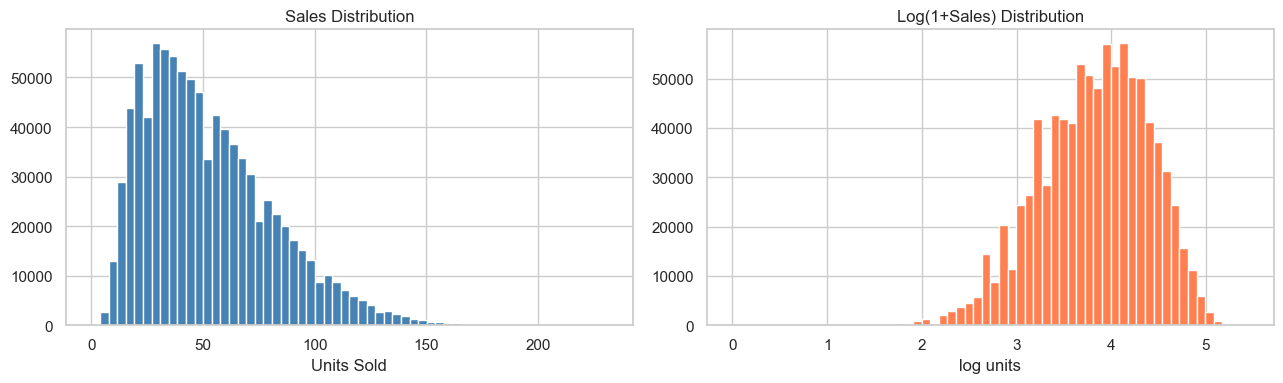

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64


In [3]:
# Sales distribution
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
train['sales'].hist(bins=60, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Sales Distribution'); axes[0].set_xlabel('Units Sold')
np.log1p(train['sales']).hist(bins=60, ax=axes[1], color='coral', edgecolor='white')
axes[1].set_title('Log(1+Sales) Distribution'); axes[1].set_xlabel('log units')
plt.tight_layout(); plt.show()
print(train['sales'].describe())

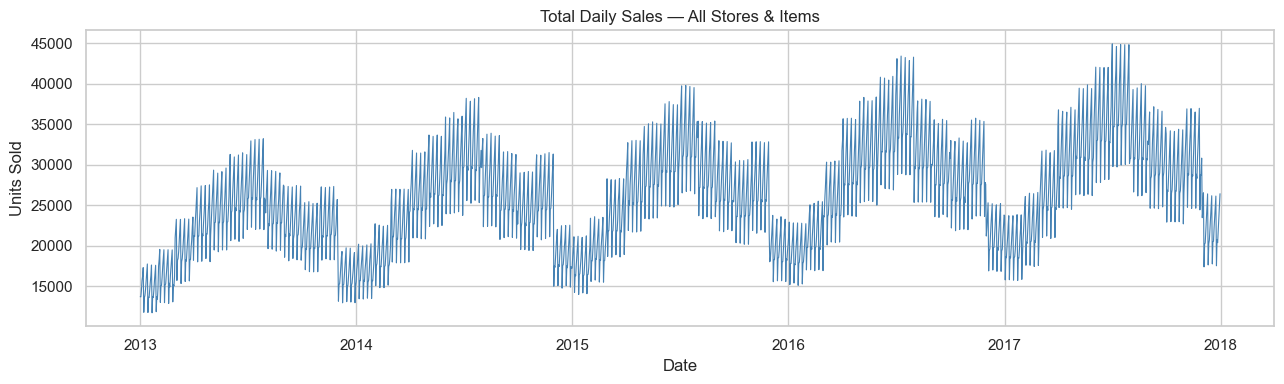

In [4]:
# Total daily sales trend
daily = train.groupby('date')['sales'].sum()
fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(daily.index, daily.values, lw=0.8, color='steelblue')
ax.set_title('Total Daily Sales — All Stores & Items')
ax.set_xlabel('Date'); ax.set_ylabel('Units Sold')
plt.tight_layout(); plt.show()

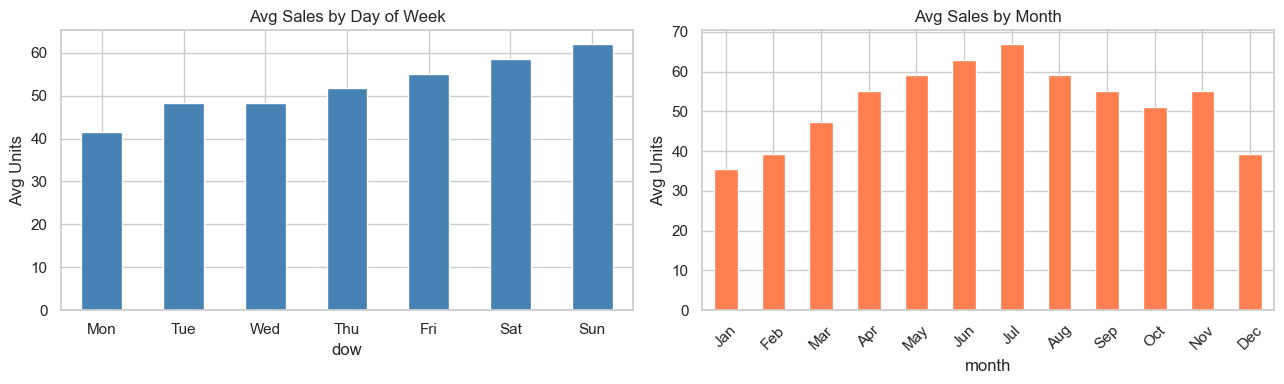

In [6]:
# Weekly & monthly patterns
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

dow = train.copy(); dow['dow'] = dow['date'].dt.dayofweek
dow.groupby('dow')['sales'].mean().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=0)
axes[0].set_title('Avg Sales by Day of Week'); axes[0].set_ylabel('Avg Units')

mon = train.copy(); mon['month'] = mon['date'].dt.month
mon.groupby('month')['sales'].mean().plot(kind='bar', ax=axes[1], color='coral', edgecolor='white')
axes[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)
axes[1].set_title('Avg Sales by Month'); axes[1].set_ylabel('Avg Units')

plt.tight_layout(); plt.show()

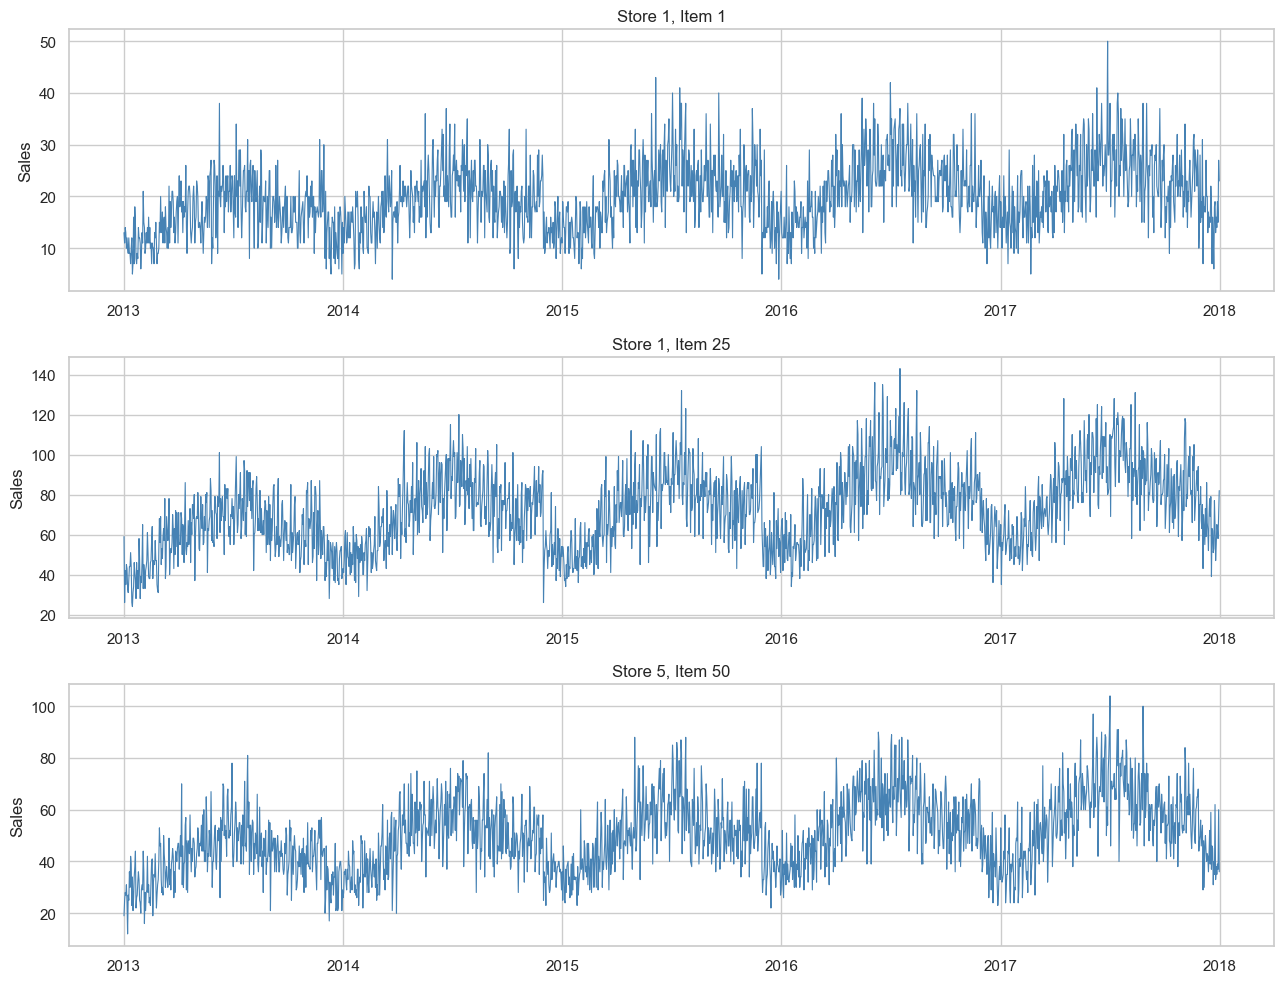

In [7]:
# Sample store-item time series
fig, axes = plt.subplots(3, 1, figsize=(13, 10))
for ax, (s, i) in zip(axes, [(1,1),(1,25),(5,50)]):
    sub = train[(train.store==s) & (train.item==i)].sort_values('date')
    ax.plot(sub['date'], sub['sales'], lw=0.8, color='steelblue')
    ax.set_title(f'Store {s}, Item {i}'); ax.set_ylabel('Sales')
plt.tight_layout(); plt.show()

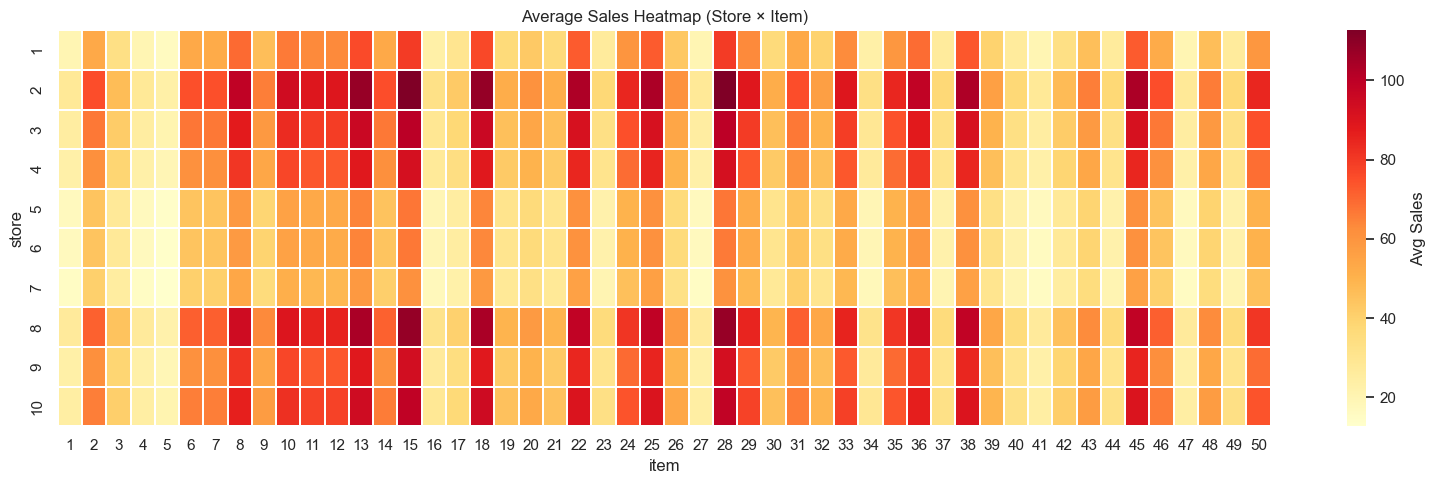

In [8]:
# Store × Item average sales heatmap
pivot = train.groupby(['store','item'])['sales'].mean().unstack('item')
fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(pivot, ax=ax, cmap='YlOrRd', linewidths=0.1, cbar_kws={'label':'Avg Sales'})
ax.set_title('Average Sales Heatmap (Store × Item)')
plt.tight_layout(); plt.show()

Top 10 most volatile items:
           mean        std        cv
item                                
5     18.358708   7.265167  0.395734
1     21.981599   8.468922  0.385273
27    22.049726   8.461641  0.383753
47    22.003341   8.420102  0.382674
41    22.002136   8.402470  0.381893
4     22.010241   8.403898  0.381818
16    25.656079   9.603270  0.374308
34    25.735761   9.617910  0.373718
49    29.335323  10.874788  0.370706
40    29.249398  10.822959  0.370023


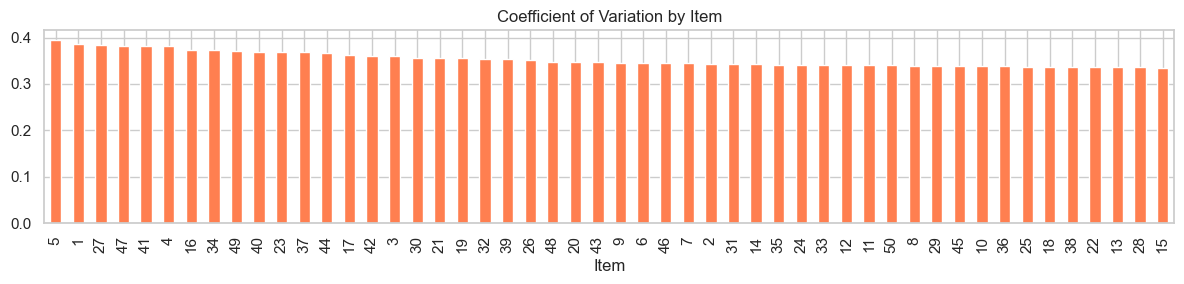

In [9]:
# Item volatility (coefficient of variation)
cv = (train.groupby('item')['sales']
      .agg(mean='mean', std='std')
      .assign(cv=lambda x: x['std']/x['mean'])
      .sort_values('cv', ascending=False))
print('Top 10 most volatile items:'); print(cv.head(10))
fig, ax = plt.subplots(figsize=(12, 3))
cv['cv'].plot(kind='bar', ax=ax, color='coral', edgecolor='white')
ax.set_title('Coefficient of Variation by Item'); ax.set_xlabel('Item')
plt.tight_layout(); plt.show()

## 3. Feature Engineering

In [10]:
def build_features(df):
    """Add time, lag, and rolling features. Expects columns: date, store, item, sales."""
    df = df.sort_values(['store','item','date']).copy()

    # Calendar
    df['year']        = df['date'].dt.year
    df['month']       = df['date'].dt.month
    df['day']         = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week']        = df['date'].dt.isocalendar().week.astype(int)
    df['quarter']     = df['date'].dt.quarter
    df['is_weekend']  = (df['day_of_week'] >= 5).astype(int)
    df['is_month_end']= df['date'].dt.is_month_end.astype(int)

    # Lag features
    g = df.groupby(['store','item'])['sales']
    for lag in [7, 14, 30]:
        df[f'lag_{lag}'] = g.shift(lag)

    # Rolling features (shift 1 to avoid leakage)
    for w in [7, 14, 30]:
        rolled = g.transform(lambda x: x.shift(1).rolling(w, min_periods=1).mean())
        df[f'roll_mean_{w}'] = rolled
        rolled_std = g.transform(lambda x: x.shift(1).rolling(w, min_periods=1).std())
        df[f'roll_std_{w}'] = rolled_std.fillna(0)

    df = df.dropna()
    return df

FEATURE_COLS = [
    'store','item',
    'year','month','day','day_of_week','day_of_year','week','quarter','is_weekend','is_month_end',
    'lag_7','lag_14','lag_30',
    'roll_mean_7','roll_mean_14','roll_mean_30',
    'roll_std_7','roll_std_14','roll_std_30',
]

print('Building features for full training set (this takes ~30s)...')
df = build_features(train)
print(f'Feature matrix: {df.shape}')
df.head(3)

Building features for full training set (this takes ~30s)...
Feature matrix: (898000, 22)


,date,store,item,sales,year,month,day,day_of_week,day_of_year,week,...,is_month_end,lag_7,lag_14,lag_30,roll_mean_7,roll_std_7,roll_mean_14,roll_std_14,roll_mean_30,roll_std_30
30,2013-01-31,1,1,13,2013,1,31,3,31,5,...,1,8.0,16.0,13.0,10.285714,2.751623,10.857143,3.759238,10.5,3.104502
31,2013-02-01,1,1,11,2013,2,1,4,32,5,...,0,14.0,7.0,11.0,11.000000,2.708013,10.642857,3.521519,10.5,3.104502
32,2013-02-02,1,1,21,2013,2,2,5,33,5,...,0,12.0,18.0,14.0,10.571429,2.370453,10.928571,3.361874,10.5,3.104502


## 4. Train / Validation Split (last 3 months = val)

In [11]:
cutoff = df['date'].max() - pd.DateOffset(months=3)
train_df = df[df['date'] <= cutoff]
val_df   = df[df['date'] >  cutoff]

X_train, y_train = train_df[FEATURE_COLS], train_df['sales']
X_val,   y_val   = val_df[FEATURE_COLS],   val_df['sales']

print(f'Train: {len(train_df):,} rows  ({train_df.date.min().date()} → {train_df.date.max().date()})')
print(f'Val  : {len(val_df):,} rows  ({val_df.date.min().date()}  → {val_df.date.max().date()})')

Train: 852,000 rows  (2013-01-31 → 2017-09-30)
Val  : 46,000 rows  (2017-10-01  → 2017-12-31)


## 5. Metrics Helper

In [12]:
def mape(actual, pred, eps=1e-8):
    actual, pred = np.array(actual, float), np.array(pred, float)
    return float(np.mean(np.abs((actual - pred) / np.maximum(np.abs(actual), eps))) * 100)

def rmse(actual, pred):
    return float(np.sqrt(np.mean((np.array(actual, float) - np.array(pred, float))**2)))

def mae(actual, pred):
    return float(np.mean(np.abs(np.array(actual, float) - np.array(pred, float))))

def r2(actual, pred):
    a = np.array(actual, float)
    ss_res = np.sum((a - np.array(pred, float))**2)
    ss_tot = np.sum((a - a.mean())**2)
    return float(1 - ss_res/ss_tot) if ss_tot > 0 else 0.0

def evaluate(actual, pred, name):
    m = {'model': name,
         'MAPE':  round(mape(actual, pred), 3),
         'RMSE':  round(rmse(actual, pred), 3),
         'MAE':   round(mae(actual, pred),  3),
         'R2':    round(r2(actual, pred),   4)}
    print(f"{name}: MAPE={m['MAPE']}%  RMSE={m['RMSE']}  MAE={m['MAE']}  R²={m['R2']}")
    return m

results = []

## 6. Model 1 — Linear Regression (Baseline)

In [13]:
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
lr_pipe.fit(X_train, y_train)

lr_preds = np.clip(lr_pipe.predict(X_val), 0, None)
lr_result = evaluate(y_val, lr_preds, 'Linear Regression')
results.append(lr_result)

joblib.dump(lr_pipe, MODELS_DIR / 'linear_regression.pkl')
print(f'Saved → {MODELS_DIR}/linear_regression.pkl')

Linear Regression: MAPE=15.662%  RMSE=9.358  MAE=7.126  R²=0.8921
Saved → D:\BISP\inventory-prediction\models/linear_regression.pkl


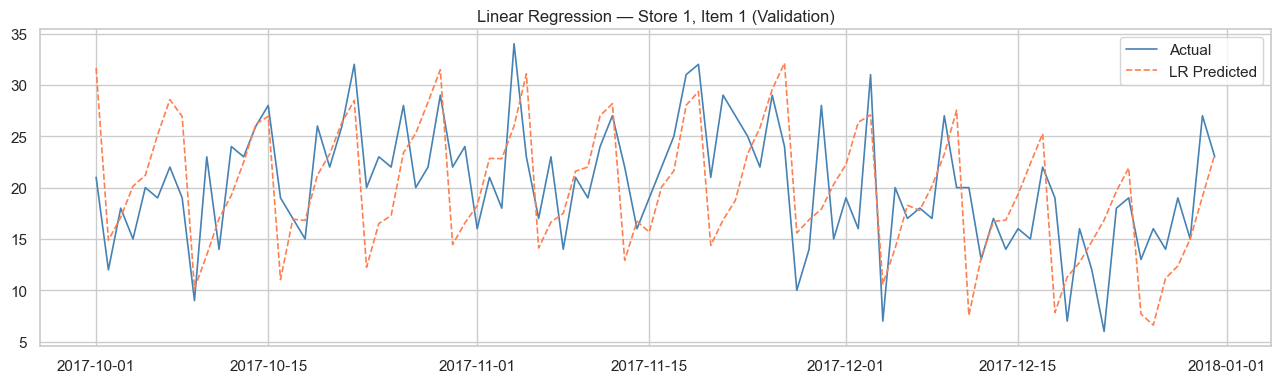

In [14]:
# Plot LR: actual vs predicted for store=1, item=1
mask = (val_df['store']==1) & (val_df['item']==1)
sub  = val_df[mask].sort_values('date')
pred = np.clip(lr_pipe.predict(sub[FEATURE_COLS]), 0, None)

fig, ax = plt.subplots(figsize=(13,4))
ax.plot(sub['date'], sub['sales'], label='Actual', color='steelblue', lw=1.2)
ax.plot(sub['date'], pred, label='LR Predicted', color='coral', lw=1.2, ls='--')
ax.set_title('Linear Regression — Store 1, Item 1 (Validation)')
ax.legend(); plt.tight_layout(); plt.show()

## 7. Model 2 — ARIMA

In [15]:
# ARIMA on 2 stores × 5 items (full 500 takes hours; this demos the approach)
try:
    from pmdarima import auto_arima
    ARIMA_AVAILABLE = True
except ImportError:
    print('pmdarima not installed. Run: pip install pmdarima')
    ARIMA_AVAILABLE = False

ARIMA_STORES = [1, 2]
ARIMA_ITEMS  = [1, 2, 3, 4, 5]

arima_models = {}
arima_actuals, arima_preds_all = [], []

if ARIMA_AVAILABLE:
    arima_cutoff = train['date'].max() - pd.DateOffset(days=90)

    for s in ARIMA_STORES:
        for i in ARIMA_ITEMS:
            sub = train[(train.store==s) & (train.item==i)].sort_values('date')
            series_train = sub[sub['date'] <= arima_cutoff].set_index('date')['sales']
            series_val   = sub[sub['date'] >  arima_cutoff]['sales'].values

            try:
                model = auto_arima(series_train, seasonal=True, m=7,
                                   max_p=2, max_q=2, max_P=1, max_Q=1,
                                   stepwise=True, suppress_warnings=True, error_action='ignore')
                forecast = np.clip(model.predict(n_periods=len(series_val)), 0, None)
                arima_models[(s,i)] = model
                arima_actuals.extend(series_val)
                arima_preds_all.extend(forecast)
                print(f'  ARIMA fitted: store={s}, item={i}  order={model.order}')
            except Exception as e:
                print(f'  ARIMA failed store={s} item={i}: {e}')

    if arima_actuals:
        arima_result = evaluate(arima_actuals, arima_preds_all, 'ARIMA')
        results.append(arima_result)
        joblib.dump(arima_models, MODELS_DIR / 'arima_models.pkl')
        print(f'Saved → {MODELS_DIR}/arima_models.pkl  ({len(arima_models)} models)')
else:
    print('Skipping ARIMA (pmdarima not available)')

  ARIMA fitted: store=1, item=1  order=(2, 1, 2)
  ARIMA fitted: store=1, item=2  order=(2, 1, 1)
  ARIMA fitted: store=1, item=3  order=(2, 1, 2)
  ARIMA fitted: store=1, item=4  order=(0, 1, 1)
  ARIMA fitted: store=1, item=5  order=(0, 1, 2)
  ARIMA fitted: store=2, item=1  order=(2, 1, 2)
  ARIMA fitted: store=2, item=2  order=(0, 1, 1)
  ARIMA fitted: store=2, item=3  order=(2, 1, 2)
  ARIMA fitted: store=2, item=4  order=(0, 1, 2)
  ARIMA fitted: store=2, item=5  order=(1, 1, 1)
ARIMA: MAPE=27.095%  RMSE=10.054  MAE=7.376  R²=0.7622
Saved → D:\BISP\inventory-prediction\models/arima_models.pkl  (10 models)


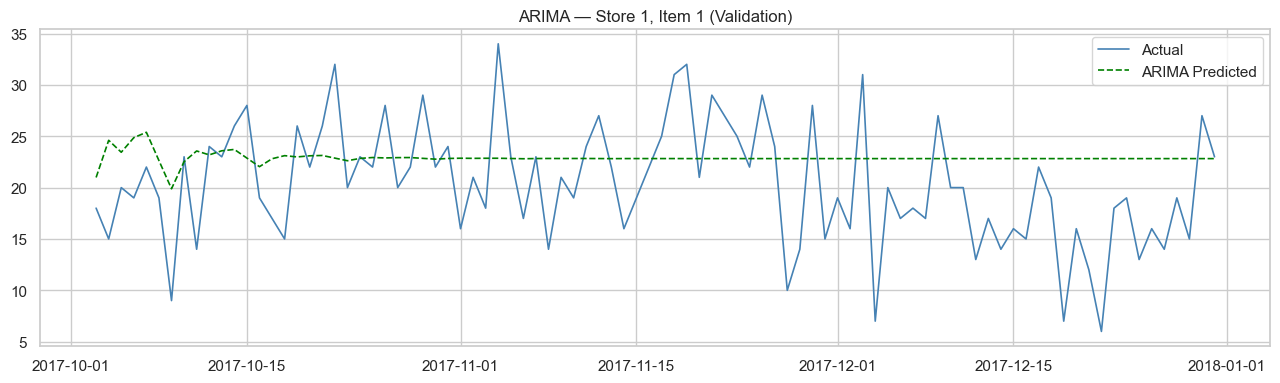

In [16]:
# Plot ARIMA: store=1, item=1
if ARIMA_AVAILABLE and (1,1) in arima_models:
    sub = train[(train.store==1)&(train.item==1)].sort_values('date')
    arima_cutoff = train['date'].max() - pd.DateOffset(days=90)
    val_sub = sub[sub['date'] > arima_cutoff]
    forecast = np.clip(arima_models[(1,1)].predict(n_periods=len(val_sub)), 0, None)

    fig, ax = plt.subplots(figsize=(13,4))
    ax.plot(val_sub['date'], val_sub['sales'], label='Actual', color='steelblue', lw=1.2)
    ax.plot(val_sub['date'].values, forecast, label='ARIMA Predicted', color='green', lw=1.2, ls='--')
    ax.set_title('ARIMA — Store 1, Item 1 (Validation)')
    ax.legend(); plt.tight_layout(); plt.show()

## 8. Model 3 — Random Forest

In [17]:
print('Training Random Forest (300 trees)... ~1-2 min on full dataset')
rf = RandomForestRegressor(
    n_estimators=300, max_depth=15, min_samples_leaf=4,
    max_features=0.6, n_jobs=-1, random_state=42
)
rf.fit(X_train, y_train)

rf_preds = np.clip(rf.predict(X_val), 0, None)
rf_result = evaluate(y_val, rf_preds, 'Random Forest')
results.append(rf_result)

joblib.dump(rf, MODELS_DIR / 'random_forest.pkl')
print(f'Saved → {MODELS_DIR}/random_forest.pkl')

Training Random Forest (300 trees)... ~1-2 min on full dataset
Random Forest: MAPE=13.346%  RMSE=7.948  MAE=6.105  R²=0.9222
Saved → D:\BISP\inventory-prediction\models/random_forest.pkl


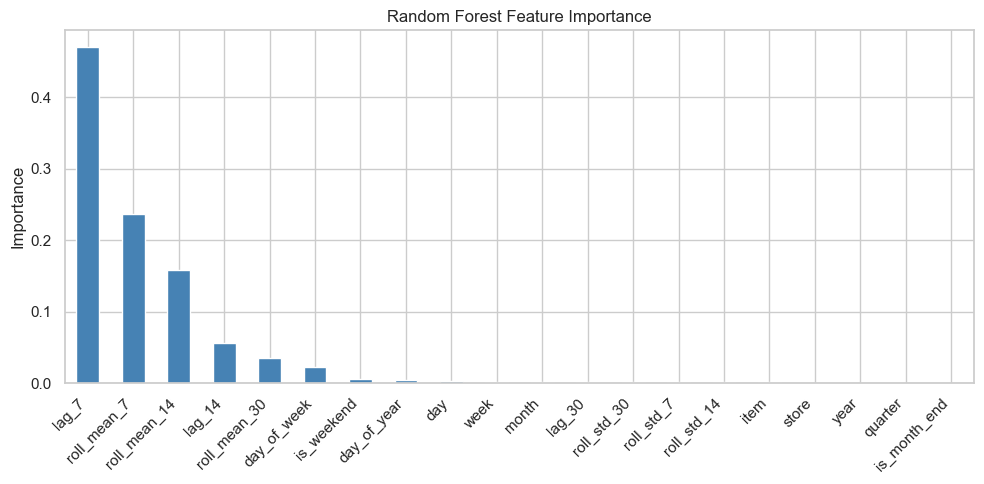

lag_7           0.469737
roll_mean_7     0.235950
roll_mean_14    0.158038
lag_14          0.056466
roll_mean_30    0.035328
day_of_week     0.021798
is_weekend      0.005271
day_of_year     0.003826
day             0.003153
week            0.001965
month           0.001862
lag_30          0.001289
roll_std_30     0.001262
roll_std_7      0.001200
roll_std_14     0.001191
item            0.000777
store           0.000485
year            0.000312
quarter         0.000070
is_month_end    0.000019
dtype: float64


In [18]:
# Feature importance
fi = pd.Series(rf.feature_importances_, index=FEATURE_COLS).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,5))
fi.plot(kind='bar', ax=ax, color='steelblue', edgecolor='white')
ax.set_title('Random Forest Feature Importance')
ax.set_ylabel('Importance'); plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()
print(fi)

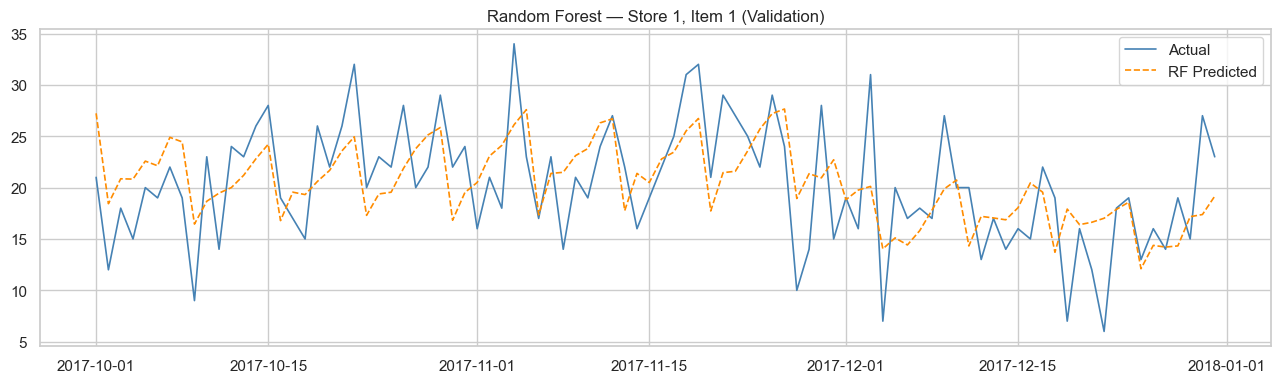

In [19]:
# Plot RF: actual vs predicted for store=1, item=1
mask = (val_df['store']==1) & (val_df['item']==1)
sub  = val_df[mask].sort_values('date')
pred = np.clip(rf.predict(sub[FEATURE_COLS]), 0, None)

fig, ax = plt.subplots(figsize=(13,4))
ax.plot(sub['date'], sub['sales'], label='Actual', color='steelblue', lw=1.2)
ax.plot(sub['date'], pred, label='RF Predicted', color='darkorange', lw=1.2, ls='--')
ax.set_title('Random Forest — Store 1, Item 1 (Validation)')
ax.legend(); plt.tight_layout(); plt.show()

## 9. Model Comparison

In [20]:
results_df = pd.DataFrame(results).set_index('model').sort_values('MAPE')
print('\n=== MODEL COMPARISON ===')
print(results_df.to_string())

# Save results
results_df.to_csv(MODELS_DIR / 'results.csv')


=== MODEL COMPARISON ===
                     MAPE    RMSE    MAE      R2
model                                           
Random Forest      13.346   7.948  6.105  0.9222
Linear Regression  15.662   9.358  7.126  0.8921
ARIMA              27.095  10.054  7.376  0.7622


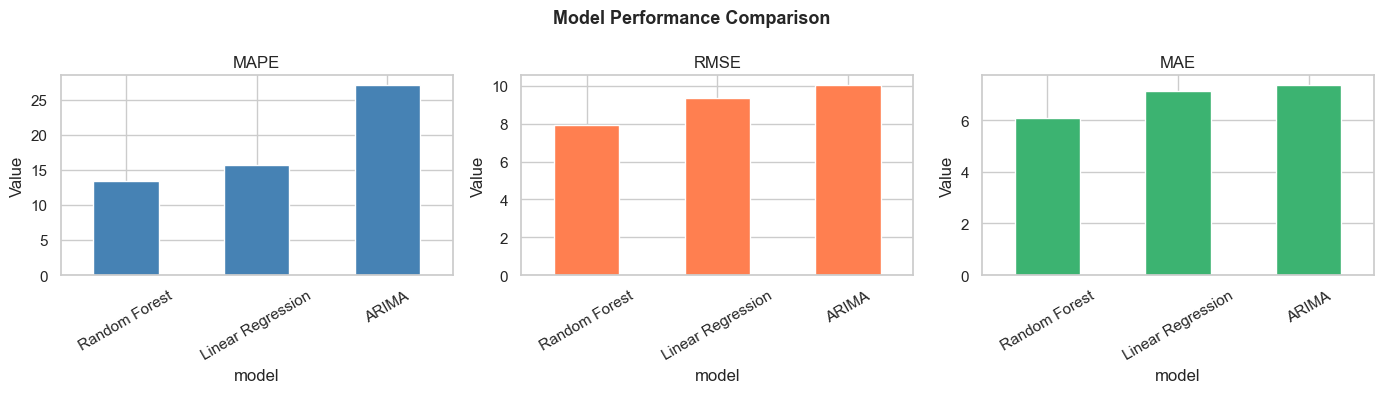

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
colors = ['steelblue', 'coral', 'mediumseagreen']
for ax, metric, color in zip(axes, ['MAPE','RMSE','MAE'], colors):
    results_df[metric].plot(kind='bar', ax=ax, color=color, edgecolor='white')
    ax.set_title(metric); ax.set_ylabel('Value'); ax.tick_params(axis='x', rotation=30)
plt.suptitle('Model Performance Comparison', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

## 11. Stock Recommendations

In [23]:
# Use last 7 days of validation predictions as a 7-day demand forecast
last7 = val_df[val_df['date'] >= val_df['date'].max() - pd.DateOffset(days=6)].copy()
last7['pred'] = np.clip(rf.predict(last7[FEATURE_COLS]), 0, None)

SAFETY_DAYS = 3   # days of safety stock
LEAD_DAYS   = 2   # supplier lead time

recs = (
    last7.groupby(['store','item'])['pred']
    .sum()
    .reset_index()
    .rename(columns={'pred': 'forecast_7d'})
)
recs['avg_daily']     = recs['forecast_7d'] / 7
recs['safety_stock']  = (recs['avg_daily'] * SAFETY_DAYS).round(1)
recs['reorder_point'] = (recs['avg_daily'] * LEAD_DAYS + recs['safety_stock']).round(1)
recs['order_qty']     = recs['forecast_7d'].round().astype(int)

print('Top 10 highest-demand store-item pairs:')
print(recs.sort_values('forecast_7d', ascending=False).head(10).to_string(index=False))

Top 10 highest-demand store-item pairs:
 store  item  forecast_7d  avg_daily  safety_stock  reorder_point  order_qty
     2    28   601.166869  85.880981         257.6          429.4        601
     8    15   597.957041  85.422434         256.3          427.1        598
     2    15   586.663092  83.809013         251.4          419.0        587
     2    25   585.807757  83.686822         251.1          418.5        586
     2    45   585.616183  83.659455         251.0          418.3        586
     2    38   585.155547  83.593650         250.8          418.0        585
     8    13   584.210765  83.458681         250.4          417.3        584
     8    38   580.396325  82.913761         248.7          414.5        580
     8    28   579.210080  82.744297         248.2          413.7        579
     2    13   577.887635  82.555376         247.7          412.8        578


## 12. Summary

**Saved models** (in `models/`):
- `linear_regression.pkl` — sklearn Pipeline (scaler + LR)
- `arima_models.pkl` — dict of `{(store, item): auto_arima model}` for demo subset
- `random_forest.pkl` — RandomForestRegressor (best overall model)
- `results.csv` — MAPE / RMSE / MAE / R² comparison table

**To load a model later:**
```python
import joblib
rf = joblib.load('models/random_forest.pkl')
preds = rf.predict(X_new)
```